# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# Note: because of a version problem with matplot lib, the following line of code doesn't work in this workspace.
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

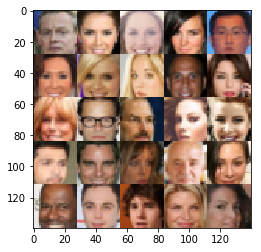

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels),
                              name='r_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='z_input')
    lr = tf.placeholder(dtype=tf.float32, name='lr')

    return r_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2 
    dropout=0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)

        flat = tf.reshape(h3, (-1, 4 * 4 * 256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(dropout_layer, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 3*3*512)
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 3x3x512
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=4, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 6x6x256
        
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=4, strides=2, padding='valid')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2, padding='same')
        out = tf.tanh(logits)
        # 28x28x5
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.2 
    dropout=0.8 
    smooth=0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
  
    dropout = 0.75
    images_to_show = 9
    losses =[]
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print("Starting trainning")
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                batch_images = 2*batch_images
                # Random Noise as input
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                # Let the generator run twice, so that the discriminator does not converge that fast.
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, z_input, channels, data_image_mode)
                    
                if step % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})

                    print("Epoch {}/{} step {}...".format(epoch_i+1, epochs, step),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if step % 100 == 0:
                    show_generator_output(sess, 16, z_input, channels, data_image_mode)
                    

    print("Finished with trainning")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Starting trainning
initial output:


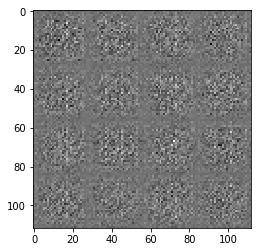

Epoch 1/2 step 10... Generator Loss: 0.2196 Discriminator Loss: 2.1098...
Epoch 1/2 step 20... Generator Loss: 0.0847 Discriminator Loss: 3.0306...
Epoch 1/2 step 30... Generator Loss: 0.3334 Discriminator Loss: 1.8097...
Epoch 1/2 step 40... Generator Loss: 3.5388 Discriminator Loss: 0.6817...
Epoch 1/2 step 50... Generator Loss: 5.8496 Discriminator Loss: 0.9937...
Epoch 1/2 step 60... Generator Loss: 4.2089 Discriminator Loss: 0.7931...
Epoch 1/2 step 70... Generator Loss: 1.7439 Discriminator Loss: 0.7172...
Epoch 1/2 step 80... Generator Loss: 3.9246 Discriminator Loss: 1.1121...
Epoch 1/2 step 90... Generator Loss: 2.8351 Discriminator Loss: 0.9106...
Epoch 1/2 step 100... Generator Loss: 3.4137 Discriminator Loss: 1.0759...


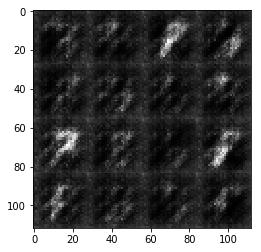

Epoch 1/2 step 110... Generator Loss: 0.3913 Discriminator Loss: 1.6799...
Epoch 1/2 step 120... Generator Loss: 1.6025 Discriminator Loss: 0.9627...
Epoch 1/2 step 130... Generator Loss: 0.6711 Discriminator Loss: 1.2980...
Epoch 1/2 step 140... Generator Loss: 1.7230 Discriminator Loss: 0.7830...
Epoch 1/2 step 150... Generator Loss: 0.3115 Discriminator Loss: 2.0429...
Epoch 1/2 step 160... Generator Loss: 0.8756 Discriminator Loss: 1.1546...
Epoch 1/2 step 170... Generator Loss: 0.4609 Discriminator Loss: 1.5507...
Epoch 1/2 step 180... Generator Loss: 0.3175 Discriminator Loss: 1.8089...
Epoch 1/2 step 190... Generator Loss: 0.4596 Discriminator Loss: 1.5548...
Epoch 1/2 step 200... Generator Loss: 2.8363 Discriminator Loss: 1.6392...


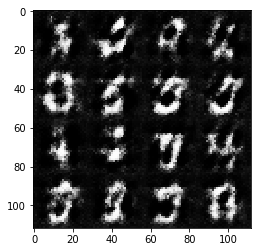

Epoch 1/2 step 210... Generator Loss: 1.8616 Discriminator Loss: 0.9151...
Epoch 1/2 step 220... Generator Loss: 1.6656 Discriminator Loss: 1.0497...
Epoch 1/2 step 230... Generator Loss: 1.4417 Discriminator Loss: 1.0076...
Epoch 1/2 step 240... Generator Loss: 0.9731 Discriminator Loss: 1.0400...
Epoch 1/2 step 250... Generator Loss: 0.6791 Discriminator Loss: 1.2154...
Epoch 1/2 step 260... Generator Loss: 0.6244 Discriminator Loss: 1.4069...
Epoch 1/2 step 270... Generator Loss: 1.2370 Discriminator Loss: 1.0519...
Epoch 1/2 step 280... Generator Loss: 1.0481 Discriminator Loss: 1.1313...
Epoch 1/2 step 290... Generator Loss: 1.7098 Discriminator Loss: 1.1406...
Epoch 1/2 step 300... Generator Loss: 1.5956 Discriminator Loss: 0.9482...


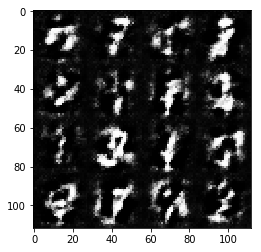

Epoch 1/2 step 310... Generator Loss: 1.2281 Discriminator Loss: 0.9578...
Epoch 1/2 step 320... Generator Loss: 1.8614 Discriminator Loss: 1.2821...
Epoch 1/2 step 330... Generator Loss: 0.7505 Discriminator Loss: 1.1302...
Epoch 1/2 step 340... Generator Loss: 0.7068 Discriminator Loss: 1.1146...
Epoch 1/2 step 350... Generator Loss: 0.5506 Discriminator Loss: 1.2948...
Epoch 1/2 step 360... Generator Loss: 1.5829 Discriminator Loss: 0.9897...
Epoch 1/2 step 370... Generator Loss: 1.2105 Discriminator Loss: 0.9030...
Epoch 1/2 step 380... Generator Loss: 0.6627 Discriminator Loss: 1.2076...
Epoch 1/2 step 390... Generator Loss: 1.8536 Discriminator Loss: 1.0766...
Epoch 1/2 step 400... Generator Loss: 1.3122 Discriminator Loss: 0.9549...


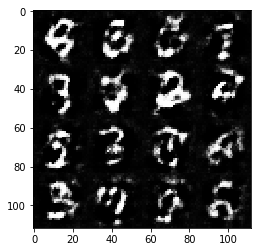

Epoch 1/2 step 410... Generator Loss: 1.8549 Discriminator Loss: 1.1171...
Epoch 1/2 step 420... Generator Loss: 0.4711 Discriminator Loss: 1.4519...
Epoch 1/2 step 430... Generator Loss: 0.5978 Discriminator Loss: 1.2224...
Epoch 1/2 step 440... Generator Loss: 1.7827 Discriminator Loss: 1.0073...
Epoch 1/2 step 450... Generator Loss: 0.8776 Discriminator Loss: 0.9902...
Epoch 1/2 step 460... Generator Loss: 1.6464 Discriminator Loss: 0.8373...
Epoch 1/2 step 470... Generator Loss: 0.5968 Discriminator Loss: 1.2592...
Epoch 1/2 step 480... Generator Loss: 0.9092 Discriminator Loss: 0.9649...
Epoch 1/2 step 490... Generator Loss: 2.3077 Discriminator Loss: 1.2443...
Epoch 1/2 step 500... Generator Loss: 1.8310 Discriminator Loss: 0.8482...


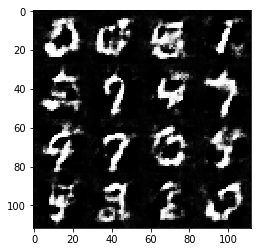

Epoch 1/2 step 510... Generator Loss: 0.4627 Discriminator Loss: 1.5260...
Epoch 1/2 step 520... Generator Loss: 0.8081 Discriminator Loss: 1.0506...
Epoch 1/2 step 530... Generator Loss: 2.0146 Discriminator Loss: 1.2692...
Epoch 1/2 step 540... Generator Loss: 0.5950 Discriminator Loss: 1.3283...
Epoch 1/2 step 550... Generator Loss: 0.7744 Discriminator Loss: 1.0830...
Epoch 1/2 step 560... Generator Loss: 1.7877 Discriminator Loss: 0.9852...
Epoch 1/2 step 570... Generator Loss: 0.8190 Discriminator Loss: 1.0660...
Epoch 1/2 step 580... Generator Loss: 0.8926 Discriminator Loss: 1.0928...
Epoch 1/2 step 590... Generator Loss: 0.4390 Discriminator Loss: 1.5145...
Epoch 1/2 step 600... Generator Loss: 1.7533 Discriminator Loss: 0.9093...


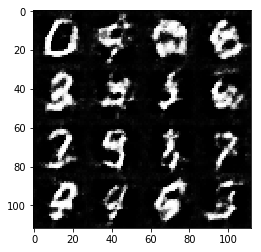

Epoch 1/2 step 610... Generator Loss: 2.4519 Discriminator Loss: 1.2852...
Epoch 1/2 step 620... Generator Loss: 0.8967 Discriminator Loss: 1.0140...
Epoch 1/2 step 630... Generator Loss: 2.2537 Discriminator Loss: 1.2187...
Epoch 1/2 step 640... Generator Loss: 1.6712 Discriminator Loss: 1.1294...
Epoch 1/2 step 650... Generator Loss: 0.8054 Discriminator Loss: 1.0545...
Epoch 1/2 step 660... Generator Loss: 0.6984 Discriminator Loss: 1.1277...
Epoch 1/2 step 670... Generator Loss: 0.5567 Discriminator Loss: 1.3166...
Epoch 1/2 step 680... Generator Loss: 1.8958 Discriminator Loss: 0.9917...
Epoch 1/2 step 690... Generator Loss: 1.0935 Discriminator Loss: 0.9561...
Epoch 1/2 step 700... Generator Loss: 1.4418 Discriminator Loss: 1.0196...


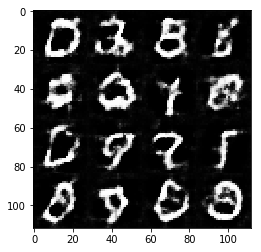

Epoch 1/2 step 710... Generator Loss: 1.1375 Discriminator Loss: 0.9110...
Epoch 1/2 step 720... Generator Loss: 1.5879 Discriminator Loss: 0.9243...
Epoch 1/2 step 730... Generator Loss: 1.9091 Discriminator Loss: 1.0968...
Epoch 1/2 step 740... Generator Loss: 0.8615 Discriminator Loss: 1.0280...
Epoch 1/2 step 750... Generator Loss: 1.1775 Discriminator Loss: 0.9432...
Epoch 1/2 step 760... Generator Loss: 1.3401 Discriminator Loss: 1.0700...
Epoch 1/2 step 770... Generator Loss: 0.6927 Discriminator Loss: 1.1430...
Epoch 1/2 step 780... Generator Loss: 1.0176 Discriminator Loss: 0.9455...
Epoch 1/2 step 790... Generator Loss: 1.8281 Discriminator Loss: 0.9825...
Epoch 1/2 step 800... Generator Loss: 0.7274 Discriminator Loss: 1.1704...


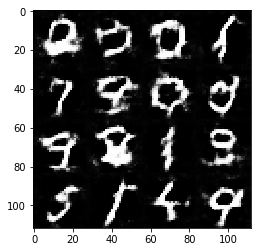

Epoch 1/2 step 810... Generator Loss: 1.0658 Discriminator Loss: 0.9649...
Epoch 1/2 step 820... Generator Loss: 0.3415 Discriminator Loss: 1.8859...
Epoch 1/2 step 830... Generator Loss: 0.9466 Discriminator Loss: 0.9803...
Epoch 1/2 step 840... Generator Loss: 0.6712 Discriminator Loss: 1.1447...
Epoch 1/2 step 850... Generator Loss: 1.0723 Discriminator Loss: 0.9387...
Epoch 1/2 step 860... Generator Loss: 1.1334 Discriminator Loss: 0.9279...
Epoch 1/2 step 870... Generator Loss: 0.9412 Discriminator Loss: 0.9811...
Epoch 1/2 step 880... Generator Loss: 1.4110 Discriminator Loss: 0.9666...
Epoch 1/2 step 890... Generator Loss: 0.7097 Discriminator Loss: 1.0907...
Epoch 1/2 step 900... Generator Loss: 0.9829 Discriminator Loss: 0.9760...


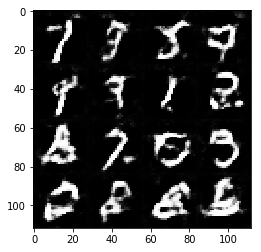

Epoch 1/2 step 910... Generator Loss: 1.0736 Discriminator Loss: 1.0293...
Epoch 1/2 step 920... Generator Loss: 3.1297 Discriminator Loss: 1.9828...
Epoch 1/2 step 930... Generator Loss: 0.7843 Discriminator Loss: 1.1112...
Epoch 1/2 step 940... Generator Loss: 1.0190 Discriminator Loss: 0.9878...
Epoch 1/2 step 950... Generator Loss: 1.3134 Discriminator Loss: 0.8646...
Epoch 1/2 step 960... Generator Loss: 2.2972 Discriminator Loss: 1.0951...
Epoch 1/2 step 970... Generator Loss: 0.7530 Discriminator Loss: 1.0650...
Epoch 1/2 step 980... Generator Loss: 0.7733 Discriminator Loss: 1.0332...
Epoch 1/2 step 990... Generator Loss: 2.3245 Discriminator Loss: 1.2905...
Epoch 1/2 step 1000... Generator Loss: 0.7347 Discriminator Loss: 1.1401...


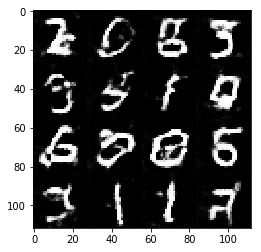

Epoch 1/2 step 1010... Generator Loss: 1.9773 Discriminator Loss: 0.9328...
Epoch 1/2 step 1020... Generator Loss: 0.9615 Discriminator Loss: 0.9196...
Epoch 1/2 step 1030... Generator Loss: 2.0762 Discriminator Loss: 1.1605...
Epoch 1/2 step 1040... Generator Loss: 0.5025 Discriminator Loss: 1.4490...
Epoch 1/2 step 1050... Generator Loss: 0.9791 Discriminator Loss: 0.9653...
Epoch 1/2 step 1060... Generator Loss: 0.8418 Discriminator Loss: 0.9970...
Epoch 1/2 step 1070... Generator Loss: 2.2792 Discriminator Loss: 1.2633...
Epoch 1/2 step 1080... Generator Loss: 0.5176 Discriminator Loss: 1.4228...
Epoch 1/2 step 1090... Generator Loss: 1.2861 Discriminator Loss: 0.8217...
Epoch 1/2 step 1100... Generator Loss: 0.7722 Discriminator Loss: 1.1119...


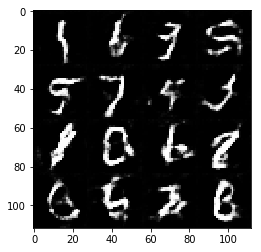

Epoch 1/2 step 1110... Generator Loss: 0.2993 Discriminator Loss: 1.8833...
Epoch 1/2 step 1120... Generator Loss: 0.7241 Discriminator Loss: 1.0971...
Epoch 1/2 step 1130... Generator Loss: 1.2037 Discriminator Loss: 0.8710...
Epoch 1/2 step 1140... Generator Loss: 0.9129 Discriminator Loss: 0.9937...
Epoch 1/2 step 1150... Generator Loss: 1.4181 Discriminator Loss: 0.7982...
Epoch 1/2 step 1160... Generator Loss: 1.4757 Discriminator Loss: 0.8836...
Epoch 1/2 step 1170... Generator Loss: 2.2636 Discriminator Loss: 0.9350...
Epoch 1/2 step 1180... Generator Loss: 1.3033 Discriminator Loss: 0.7627...
Epoch 1/2 step 1190... Generator Loss: 3.4944 Discriminator Loss: 2.2955...
Epoch 1/2 step 1200... Generator Loss: 1.3344 Discriminator Loss: 0.8345...


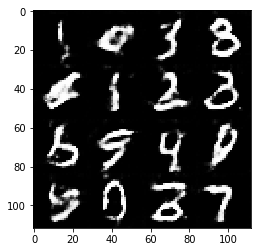

Epoch 1/2 step 1210... Generator Loss: 0.7351 Discriminator Loss: 1.1453...
Epoch 1/2 step 1220... Generator Loss: 1.0409 Discriminator Loss: 0.9821...
Epoch 1/2 step 1230... Generator Loss: 1.4748 Discriminator Loss: 0.7495...
Epoch 1/2 step 1240... Generator Loss: 1.4670 Discriminator Loss: 0.9337...
Epoch 1/2 step 1250... Generator Loss: 0.4870 Discriminator Loss: 1.4384...
Epoch 1/2 step 1260... Generator Loss: 0.3382 Discriminator Loss: 1.8362...
Epoch 1/2 step 1270... Generator Loss: 0.9584 Discriminator Loss: 0.9324...
Epoch 1/2 step 1280... Generator Loss: 0.8456 Discriminator Loss: 0.9738...
Epoch 1/2 step 1290... Generator Loss: 1.1398 Discriminator Loss: 0.8080...
Epoch 1/2 step 1300... Generator Loss: 1.9703 Discriminator Loss: 1.2714...


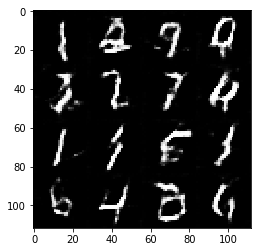

Epoch 1/2 step 1310... Generator Loss: 0.8496 Discriminator Loss: 1.0026...
Epoch 1/2 step 1320... Generator Loss: 0.8661 Discriminator Loss: 0.9572...
Epoch 1/2 step 1330... Generator Loss: 0.4956 Discriminator Loss: 1.4601...
Epoch 1/2 step 1340... Generator Loss: 0.6003 Discriminator Loss: 1.2162...
Epoch 1/2 step 1350... Generator Loss: 0.7858 Discriminator Loss: 1.0195...
Epoch 1/2 step 1360... Generator Loss: 0.3968 Discriminator Loss: 1.6440...
Epoch 1/2 step 1370... Generator Loss: 2.0349 Discriminator Loss: 0.8866...
Epoch 1/2 step 1380... Generator Loss: 0.7249 Discriminator Loss: 1.0881...
Epoch 1/2 step 1390... Generator Loss: 1.1249 Discriminator Loss: 0.7964...
Epoch 1/2 step 1400... Generator Loss: 1.5214 Discriminator Loss: 0.7596...


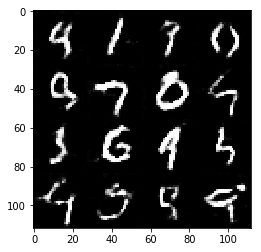

Epoch 1/2 step 1410... Generator Loss: 1.2741 Discriminator Loss: 0.7475...
Epoch 1/2 step 1420... Generator Loss: 1.8270 Discriminator Loss: 0.7336...
Epoch 1/2 step 1430... Generator Loss: 1.7435 Discriminator Loss: 0.7875...
Epoch 1/2 step 1440... Generator Loss: 1.2178 Discriminator Loss: 0.7923...
Epoch 1/2 step 1450... Generator Loss: 1.1958 Discriminator Loss: 0.8344...
Epoch 1/2 step 1460... Generator Loss: 0.5582 Discriminator Loss: 1.3244...
Epoch 1/2 step 1470... Generator Loss: 1.2320 Discriminator Loss: 0.8177...
Epoch 1/2 step 1480... Generator Loss: 0.9899 Discriminator Loss: 0.8762...
Epoch 1/2 step 1490... Generator Loss: 3.4405 Discriminator Loss: 1.7147...
Epoch 1/2 step 1500... Generator Loss: 0.7832 Discriminator Loss: 1.0010...


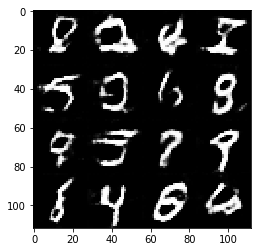

Epoch 1/2 step 1510... Generator Loss: 1.1333 Discriminator Loss: 0.8589...
Epoch 1/2 step 1520... Generator Loss: 1.3037 Discriminator Loss: 0.7151...
Epoch 1/2 step 1530... Generator Loss: 0.6875 Discriminator Loss: 1.1921...
Epoch 1/2 step 1540... Generator Loss: 0.7717 Discriminator Loss: 1.0250...
Epoch 1/2 step 1550... Generator Loss: 1.1202 Discriminator Loss: 0.7775...
Epoch 1/2 step 1560... Generator Loss: 0.9558 Discriminator Loss: 0.8997...
Epoch 1/2 step 1570... Generator Loss: 0.9170 Discriminator Loss: 0.9774...
Epoch 1/2 step 1580... Generator Loss: 0.9760 Discriminator Loss: 0.9009...
Epoch 1/2 step 1590... Generator Loss: 1.4608 Discriminator Loss: 0.7028...
Epoch 1/2 step 1600... Generator Loss: 1.7878 Discriminator Loss: 0.9768...


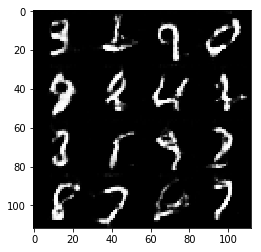

Epoch 1/2 step 1610... Generator Loss: 1.3412 Discriminator Loss: 0.8932...
Epoch 1/2 step 1620... Generator Loss: 1.4248 Discriminator Loss: 0.9199...
Epoch 1/2 step 1630... Generator Loss: 0.8761 Discriminator Loss: 0.9487...
Epoch 1/2 step 1640... Generator Loss: 1.3082 Discriminator Loss: 0.7444...
Epoch 1/2 step 1650... Generator Loss: 1.0779 Discriminator Loss: 0.8320...
Epoch 1/2 step 1660... Generator Loss: 1.4044 Discriminator Loss: 0.7104...
Epoch 1/2 step 1670... Generator Loss: 1.0835 Discriminator Loss: 0.8250...
Epoch 1/2 step 1680... Generator Loss: 1.1225 Discriminator Loss: 0.8964...
Epoch 1/2 step 1690... Generator Loss: 0.2277 Discriminator Loss: 2.1203...
Epoch 1/2 step 1700... Generator Loss: 0.8849 Discriminator Loss: 1.0236...


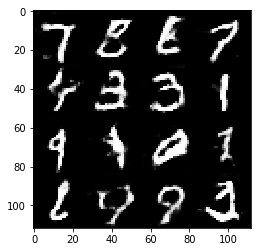

Epoch 1/2 step 1710... Generator Loss: 0.8975 Discriminator Loss: 0.9600...
Epoch 1/2 step 1720... Generator Loss: 0.5320 Discriminator Loss: 1.3683...
Epoch 1/2 step 1730... Generator Loss: 1.8316 Discriminator Loss: 0.6959...
Epoch 1/2 step 1740... Generator Loss: 1.2625 Discriminator Loss: 0.7629...
Epoch 1/2 step 1750... Generator Loss: 0.6732 Discriminator Loss: 1.2166...
Epoch 1/2 step 1760... Generator Loss: 1.4423 Discriminator Loss: 0.6618...
Epoch 1/2 step 1770... Generator Loss: 1.7341 Discriminator Loss: 0.8968...
Epoch 1/2 step 1780... Generator Loss: 1.5932 Discriminator Loss: 0.6892...
Epoch 1/2 step 1790... Generator Loss: 1.2105 Discriminator Loss: 0.7662...
Epoch 1/2 step 1800... Generator Loss: 0.9285 Discriminator Loss: 1.0562...


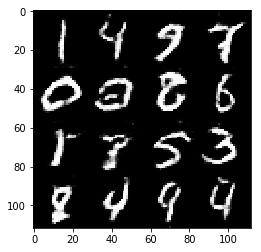

Epoch 1/2 step 1810... Generator Loss: 0.6357 Discriminator Loss: 1.1862...
Epoch 1/2 step 1820... Generator Loss: 2.3535 Discriminator Loss: 0.6679...
Epoch 1/2 step 1830... Generator Loss: 1.3240 Discriminator Loss: 0.8963...
Epoch 1/2 step 1840... Generator Loss: 0.7581 Discriminator Loss: 1.1204...
Epoch 1/2 step 1850... Generator Loss: 1.2780 Discriminator Loss: 0.8284...
Epoch 1/2 step 1860... Generator Loss: 0.4904 Discriminator Loss: 1.4717...
Epoch 1/2 step 1870... Generator Loss: 0.7893 Discriminator Loss: 1.0885...
Epoch 2/2 step 1880... Generator Loss: 1.1181 Discriminator Loss: 0.8020...
Epoch 2/2 step 1890... Generator Loss: 0.6547 Discriminator Loss: 1.1934...
Epoch 2/2 step 1900... Generator Loss: 0.7705 Discriminator Loss: 1.0449...


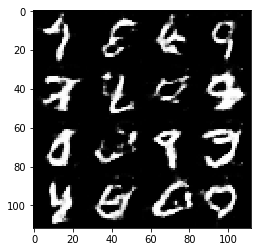

Epoch 2/2 step 1910... Generator Loss: 1.2971 Discriminator Loss: 0.7796...
Epoch 2/2 step 1920... Generator Loss: 0.6884 Discriminator Loss: 1.1742...
Epoch 2/2 step 1930... Generator Loss: 0.5955 Discriminator Loss: 1.2415...
Epoch 2/2 step 1940... Generator Loss: 0.9682 Discriminator Loss: 0.9603...
Epoch 2/2 step 1950... Generator Loss: 1.6877 Discriminator Loss: 0.6427...
Epoch 2/2 step 1960... Generator Loss: 0.9472 Discriminator Loss: 0.9091...
Epoch 2/2 step 1970... Generator Loss: 0.9152 Discriminator Loss: 0.9495...
Epoch 2/2 step 1980... Generator Loss: 0.7665 Discriminator Loss: 1.0341...
Epoch 2/2 step 1990... Generator Loss: 1.6204 Discriminator Loss: 1.3357...
Epoch 2/2 step 2000... Generator Loss: 1.1979 Discriminator Loss: 0.8253...


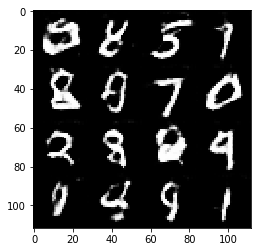

Epoch 2/2 step 2010... Generator Loss: 1.1078 Discriminator Loss: 0.8497...
Epoch 2/2 step 2020... Generator Loss: 0.8558 Discriminator Loss: 0.9475...
Epoch 2/2 step 2030... Generator Loss: 1.9692 Discriminator Loss: 0.8769...
Epoch 2/2 step 2040... Generator Loss: 1.0930 Discriminator Loss: 0.8483...
Epoch 2/2 step 2050... Generator Loss: 2.9753 Discriminator Loss: 1.1541...
Epoch 2/2 step 2060... Generator Loss: 1.3691 Discriminator Loss: 0.7907...
Epoch 2/2 step 2070... Generator Loss: 0.8234 Discriminator Loss: 1.0503...
Epoch 2/2 step 2080... Generator Loss: 1.8782 Discriminator Loss: 0.7487...
Epoch 2/2 step 2090... Generator Loss: 0.9991 Discriminator Loss: 0.8621...
Epoch 2/2 step 2100... Generator Loss: 0.5780 Discriminator Loss: 1.3053...


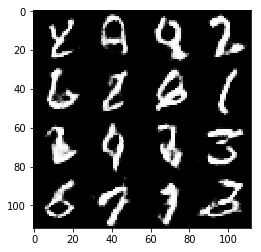

Epoch 2/2 step 2110... Generator Loss: 1.5542 Discriminator Loss: 0.7734...
Epoch 2/2 step 2120... Generator Loss: 1.3027 Discriminator Loss: 0.7295...
Epoch 2/2 step 2130... Generator Loss: 1.1389 Discriminator Loss: 0.8540...
Epoch 2/2 step 2140... Generator Loss: 1.0832 Discriminator Loss: 0.8077...
Epoch 2/2 step 2150... Generator Loss: 1.2116 Discriminator Loss: 0.8352...
Epoch 2/2 step 2160... Generator Loss: 1.8604 Discriminator Loss: 0.7107...
Epoch 2/2 step 2170... Generator Loss: 1.1617 Discriminator Loss: 0.8240...
Epoch 2/2 step 2180... Generator Loss: 1.4116 Discriminator Loss: 0.7477...
Epoch 2/2 step 2190... Generator Loss: 0.6556 Discriminator Loss: 1.2338...
Epoch 2/2 step 2200... Generator Loss: 1.6253 Discriminator Loss: 0.6516...


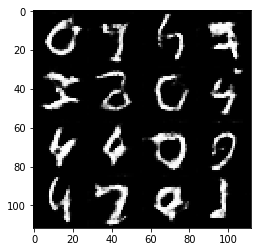

Epoch 2/2 step 2210... Generator Loss: 1.4190 Discriminator Loss: 0.7002...
Epoch 2/2 step 2220... Generator Loss: 1.7821 Discriminator Loss: 0.7485...
Epoch 2/2 step 2230... Generator Loss: 2.2494 Discriminator Loss: 1.3877...
Epoch 2/2 step 2240... Generator Loss: 1.1708 Discriminator Loss: 0.7806...
Epoch 2/2 step 2250... Generator Loss: 1.3135 Discriminator Loss: 0.7608...
Epoch 2/2 step 2260... Generator Loss: 1.2403 Discriminator Loss: 0.7685...
Epoch 2/2 step 2270... Generator Loss: 1.2191 Discriminator Loss: 0.7328...
Epoch 2/2 step 2280... Generator Loss: 1.1100 Discriminator Loss: 1.0689...
Epoch 2/2 step 2290... Generator Loss: 0.6434 Discriminator Loss: 1.2818...
Epoch 2/2 step 2300... Generator Loss: 1.2301 Discriminator Loss: 0.8332...


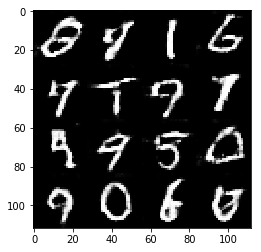

Epoch 2/2 step 2310... Generator Loss: 1.6043 Discriminator Loss: 0.6507...
Epoch 2/2 step 2320... Generator Loss: 0.7007 Discriminator Loss: 1.1552...
Epoch 2/2 step 2330... Generator Loss: 0.8851 Discriminator Loss: 1.0094...
Epoch 2/2 step 2340... Generator Loss: 1.2206 Discriminator Loss: 0.8001...
Epoch 2/2 step 2350... Generator Loss: 1.9452 Discriminator Loss: 0.6817...
Epoch 2/2 step 2360... Generator Loss: 1.1304 Discriminator Loss: 0.8168...
Epoch 2/2 step 2370... Generator Loss: 1.3719 Discriminator Loss: 0.7235...
Epoch 2/2 step 2380... Generator Loss: 4.3663 Discriminator Loss: 2.4262...
Epoch 2/2 step 2390... Generator Loss: 0.5769 Discriminator Loss: 1.3434...
Epoch 2/2 step 2400... Generator Loss: 0.7992 Discriminator Loss: 1.0305...


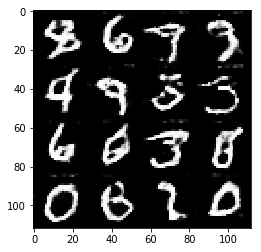

Epoch 2/2 step 2410... Generator Loss: 0.7654 Discriminator Loss: 1.1270...
Epoch 2/2 step 2420... Generator Loss: 0.9391 Discriminator Loss: 0.9241...
Epoch 2/2 step 2430... Generator Loss: 1.0605 Discriminator Loss: 0.8498...
Epoch 2/2 step 2440... Generator Loss: 2.4381 Discriminator Loss: 0.6995...
Epoch 2/2 step 2450... Generator Loss: 1.1729 Discriminator Loss: 0.8304...
Epoch 2/2 step 2460... Generator Loss: 1.7369 Discriminator Loss: 0.6472...
Epoch 2/2 step 2470... Generator Loss: 0.8939 Discriminator Loss: 0.9981...
Epoch 2/2 step 2480... Generator Loss: 1.0911 Discriminator Loss: 0.8239...
Epoch 2/2 step 2490... Generator Loss: 1.1162 Discriminator Loss: 0.8437...
Epoch 2/2 step 2500... Generator Loss: 0.8654 Discriminator Loss: 0.9999...


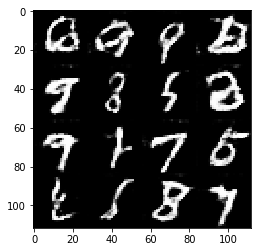

Epoch 2/2 step 2510... Generator Loss: 1.5021 Discriminator Loss: 0.6456...
Epoch 2/2 step 2520... Generator Loss: 0.6170 Discriminator Loss: 1.2431...
Epoch 2/2 step 2530... Generator Loss: 2.3495 Discriminator Loss: 1.0025...
Epoch 2/2 step 2540... Generator Loss: 1.0458 Discriminator Loss: 0.8589...
Epoch 2/2 step 2550... Generator Loss: 0.3261 Discriminator Loss: 1.9259...
Epoch 2/2 step 2560... Generator Loss: 0.8563 Discriminator Loss: 0.9885...
Epoch 2/2 step 2570... Generator Loss: 0.7141 Discriminator Loss: 1.1557...
Epoch 2/2 step 2580... Generator Loss: 0.6851 Discriminator Loss: 1.2378...
Epoch 2/2 step 2590... Generator Loss: 1.7265 Discriminator Loss: 0.6815...
Epoch 2/2 step 2600... Generator Loss: 1.0992 Discriminator Loss: 0.8708...


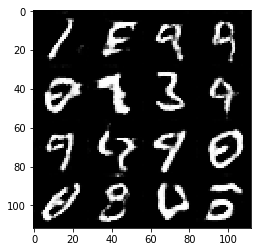

Epoch 2/2 step 2610... Generator Loss: 1.0226 Discriminator Loss: 0.8983...
Epoch 2/2 step 2620... Generator Loss: 0.7281 Discriminator Loss: 1.1101...
Epoch 2/2 step 2630... Generator Loss: 0.6348 Discriminator Loss: 1.2464...
Epoch 2/2 step 2640... Generator Loss: 1.3676 Discriminator Loss: 0.8908...
Epoch 2/2 step 2650... Generator Loss: 3.2183 Discriminator Loss: 1.0841...
Epoch 2/2 step 2660... Generator Loss: 0.5795 Discriminator Loss: 1.4425...
Epoch 2/2 step 2670... Generator Loss: 1.3286 Discriminator Loss: 0.8160...
Epoch 2/2 step 2680... Generator Loss: 1.7075 Discriminator Loss: 0.7981...
Epoch 2/2 step 2690... Generator Loss: 1.7683 Discriminator Loss: 0.7439...
Epoch 2/2 step 2700... Generator Loss: 1.7369 Discriminator Loss: 0.6466...


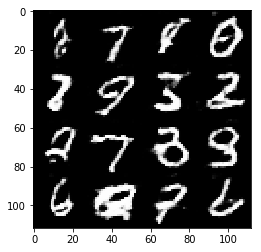

Epoch 2/2 step 2710... Generator Loss: 1.4619 Discriminator Loss: 0.6521...
Epoch 2/2 step 2720... Generator Loss: 1.3525 Discriminator Loss: 0.7489...
Epoch 2/2 step 2730... Generator Loss: 1.5230 Discriminator Loss: 0.7294...
Epoch 2/2 step 2740... Generator Loss: 1.2418 Discriminator Loss: 0.7916...
Epoch 2/2 step 2750... Generator Loss: 1.0590 Discriminator Loss: 0.8705...
Epoch 2/2 step 2760... Generator Loss: 0.3567 Discriminator Loss: 2.1941...
Epoch 2/2 step 2770... Generator Loss: 1.2952 Discriminator Loss: 0.7338...
Epoch 2/2 step 2780... Generator Loss: 1.5151 Discriminator Loss: 0.6409...
Epoch 2/2 step 2790... Generator Loss: 3.3804 Discriminator Loss: 1.1859...
Epoch 2/2 step 2800... Generator Loss: 2.0864 Discriminator Loss: 0.7152...


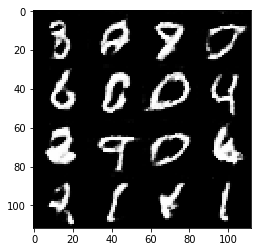

Epoch 2/2 step 2810... Generator Loss: 2.9630 Discriminator Loss: 1.2451...
Epoch 2/2 step 2820... Generator Loss: 2.4539 Discriminator Loss: 0.7402...
Epoch 2/2 step 2830... Generator Loss: 1.0811 Discriminator Loss: 0.8340...
Epoch 2/2 step 2840... Generator Loss: 1.4916 Discriminator Loss: 0.6518...
Epoch 2/2 step 2850... Generator Loss: 0.3279 Discriminator Loss: 1.8486...
Epoch 2/2 step 2860... Generator Loss: 1.5675 Discriminator Loss: 0.6706...
Epoch 2/2 step 2870... Generator Loss: 1.6017 Discriminator Loss: 0.6604...
Epoch 2/2 step 2880... Generator Loss: 1.1367 Discriminator Loss: 0.8095...
Epoch 2/2 step 2890... Generator Loss: 1.0723 Discriminator Loss: 0.8313...
Epoch 2/2 step 2900... Generator Loss: 1.3298 Discriminator Loss: 0.7243...


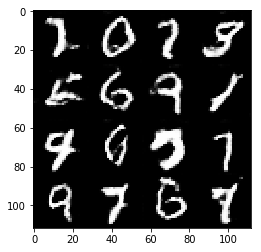

Epoch 2/2 step 2910... Generator Loss: 1.7379 Discriminator Loss: 0.5773...
Epoch 2/2 step 2920... Generator Loss: 1.4570 Discriminator Loss: 0.6986...
Epoch 2/2 step 2930... Generator Loss: 0.8469 Discriminator Loss: 1.0388...
Epoch 2/2 step 2940... Generator Loss: 0.9008 Discriminator Loss: 0.9469...
Epoch 2/2 step 2950... Generator Loss: 2.0718 Discriminator Loss: 0.7387...
Epoch 2/2 step 2960... Generator Loss: 4.7045 Discriminator Loss: 1.3954...
Epoch 2/2 step 2970... Generator Loss: 3.1078 Discriminator Loss: 0.6502...
Epoch 2/2 step 2980... Generator Loss: 1.4049 Discriminator Loss: 0.6900...
Epoch 2/2 step 2990... Generator Loss: 1.7696 Discriminator Loss: 0.6244...
Epoch 2/2 step 3000... Generator Loss: 0.6309 Discriminator Loss: 1.2513...


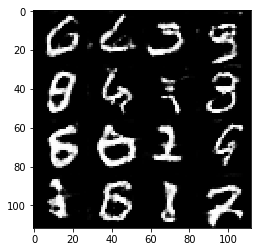

Epoch 2/2 step 3010... Generator Loss: 0.9501 Discriminator Loss: 0.8935...
Epoch 2/2 step 3020... Generator Loss: 0.7266 Discriminator Loss: 1.1130...
Epoch 2/2 step 3030... Generator Loss: 1.1814 Discriminator Loss: 0.7849...
Epoch 2/2 step 3040... Generator Loss: 0.7243 Discriminator Loss: 1.1276...
Epoch 2/2 step 3050... Generator Loss: 1.3493 Discriminator Loss: 0.7844...
Epoch 2/2 step 3060... Generator Loss: 0.8332 Discriminator Loss: 1.0385...
Epoch 2/2 step 3070... Generator Loss: 1.7398 Discriminator Loss: 0.5743...
Epoch 2/2 step 3080... Generator Loss: 1.3517 Discriminator Loss: 0.7389...
Epoch 2/2 step 3090... Generator Loss: 1.1189 Discriminator Loss: 0.8541...
Epoch 2/2 step 3100... Generator Loss: 1.3148 Discriminator Loss: 0.7537...


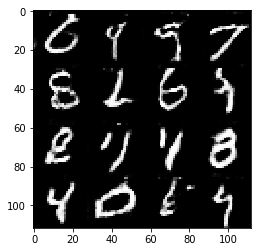

Epoch 2/2 step 3110... Generator Loss: 0.9275 Discriminator Loss: 0.9274...
Epoch 2/2 step 3120... Generator Loss: 0.9338 Discriminator Loss: 1.0300...
Epoch 2/2 step 3130... Generator Loss: 0.8178 Discriminator Loss: 1.1123...
Epoch 2/2 step 3140... Generator Loss: 0.8964 Discriminator Loss: 0.9962...
Epoch 2/2 step 3150... Generator Loss: 1.4514 Discriminator Loss: 0.6971...
Epoch 2/2 step 3160... Generator Loss: 1.6603 Discriminator Loss: 0.7238...
Epoch 2/2 step 3170... Generator Loss: 0.6524 Discriminator Loss: 1.3255...
Epoch 2/2 step 3180... Generator Loss: 0.3119 Discriminator Loss: 2.0927...
Epoch 2/2 step 3190... Generator Loss: 1.5288 Discriminator Loss: 0.7012...
Epoch 2/2 step 3200... Generator Loss: 1.1441 Discriminator Loss: 0.8411...


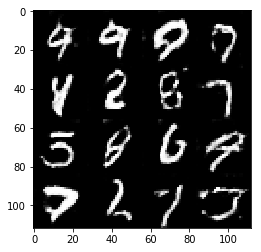

Epoch 2/2 step 3210... Generator Loss: 0.6618 Discriminator Loss: 1.2454...
Epoch 2/2 step 3220... Generator Loss: 1.4500 Discriminator Loss: 0.6679...
Epoch 2/2 step 3230... Generator Loss: 2.9475 Discriminator Loss: 0.9694...
Epoch 2/2 step 3240... Generator Loss: 0.4802 Discriminator Loss: 1.5269...
Epoch 2/2 step 3250... Generator Loss: 1.1754 Discriminator Loss: 0.7818...
Epoch 2/2 step 3260... Generator Loss: 1.3223 Discriminator Loss: 0.7237...
Epoch 2/2 step 3270... Generator Loss: 0.4965 Discriminator Loss: 1.4697...
Epoch 2/2 step 3280... Generator Loss: 0.9032 Discriminator Loss: 0.9611...
Epoch 2/2 step 3290... Generator Loss: 1.3376 Discriminator Loss: 0.7035...
Epoch 2/2 step 3300... Generator Loss: 0.9080 Discriminator Loss: 1.0056...


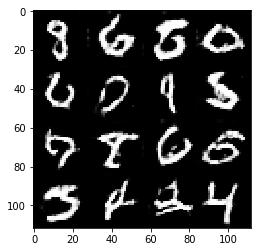

Epoch 2/2 step 3310... Generator Loss: 2.0253 Discriminator Loss: 0.5309...
Epoch 2/2 step 3320... Generator Loss: 1.0453 Discriminator Loss: 0.9095...
Epoch 2/2 step 3330... Generator Loss: 0.7137 Discriminator Loss: 1.1759...
Epoch 2/2 step 3340... Generator Loss: 5.9692 Discriminator Loss: 2.1880...
Epoch 2/2 step 3350... Generator Loss: 1.2987 Discriminator Loss: 0.8127...
Epoch 2/2 step 3360... Generator Loss: 1.4302 Discriminator Loss: 0.6787...
Epoch 2/2 step 3370... Generator Loss: 1.4172 Discriminator Loss: 0.7005...
Epoch 2/2 step 3380... Generator Loss: 1.9014 Discriminator Loss: 0.5306...
Epoch 2/2 step 3390... Generator Loss: 1.5923 Discriminator Loss: 0.6629...
Epoch 2/2 step 3400... Generator Loss: 1.0578 Discriminator Loss: 0.8379...


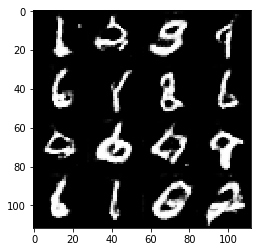

Epoch 2/2 step 3410... Generator Loss: 1.1594 Discriminator Loss: 0.8149...
Epoch 2/2 step 3420... Generator Loss: 1.3723 Discriminator Loss: 0.6993...
Epoch 2/2 step 3430... Generator Loss: 1.9905 Discriminator Loss: 0.5467...
Epoch 2/2 step 3440... Generator Loss: 1.9743 Discriminator Loss: 0.5868...
Epoch 2/2 step 3450... Generator Loss: 2.1027 Discriminator Loss: 0.5512...
Epoch 2/2 step 3460... Generator Loss: 0.3803 Discriminator Loss: 1.8242...
Epoch 2/2 step 3470... Generator Loss: 2.0702 Discriminator Loss: 0.6207...
Epoch 2/2 step 3480... Generator Loss: 1.7472 Discriminator Loss: 0.6000...
Epoch 2/2 step 3490... Generator Loss: 2.5827 Discriminator Loss: 1.0924...
Epoch 2/2 step 3500... Generator Loss: 1.3095 Discriminator Loss: 0.7388...


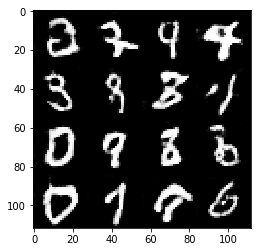

Epoch 2/2 step 3510... Generator Loss: 0.8110 Discriminator Loss: 1.0305...
Epoch 2/2 step 3520... Generator Loss: 1.8777 Discriminator Loss: 0.5933...
Epoch 2/2 step 3530... Generator Loss: 1.2346 Discriminator Loss: 0.7808...
Epoch 2/2 step 3540... Generator Loss: 0.7513 Discriminator Loss: 1.0979...
Epoch 2/2 step 3550... Generator Loss: 1.6462 Discriminator Loss: 0.6318...
Epoch 2/2 step 3560... Generator Loss: 1.4439 Discriminator Loss: 0.7327...
Epoch 2/2 step 3570... Generator Loss: 2.1468 Discriminator Loss: 0.4956...
Epoch 2/2 step 3580... Generator Loss: 1.9892 Discriminator Loss: 0.6179...
Epoch 2/2 step 3590... Generator Loss: 1.3447 Discriminator Loss: 0.7303...
Epoch 2/2 step 3600... Generator Loss: 1.6471 Discriminator Loss: 0.6526...


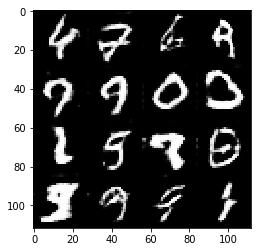

Epoch 2/2 step 3610... Generator Loss: 0.5026 Discriminator Loss: 1.4267...
Epoch 2/2 step 3620... Generator Loss: 1.4304 Discriminator Loss: 0.6711...
Epoch 2/2 step 3630... Generator Loss: 0.9825 Discriminator Loss: 0.9007...
Epoch 2/2 step 3640... Generator Loss: 1.0245 Discriminator Loss: 0.8839...
Epoch 2/2 step 3650... Generator Loss: 1.1467 Discriminator Loss: 0.8001...
Epoch 2/2 step 3660... Generator Loss: 2.5359 Discriminator Loss: 0.5573...
Epoch 2/2 step 3670... Generator Loss: 1.3315 Discriminator Loss: 0.7164...
Epoch 2/2 step 3680... Generator Loss: 2.1950 Discriminator Loss: 0.6671...
Epoch 2/2 step 3690... Generator Loss: 1.9918 Discriminator Loss: 0.6593...
Epoch 2/2 step 3700... Generator Loss: 0.9109 Discriminator Loss: 1.0176...


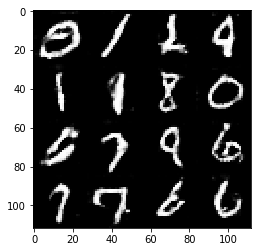

Epoch 2/2 step 3710... Generator Loss: 2.9169 Discriminator Loss: 0.9864...
Epoch 2/2 step 3720... Generator Loss: 2.5171 Discriminator Loss: 0.7995...
Epoch 2/2 step 3730... Generator Loss: 0.8689 Discriminator Loss: 0.9916...
Epoch 2/2 step 3740... Generator Loss: 0.6423 Discriminator Loss: 1.2383...
Epoch 2/2 step 3750... Generator Loss: 0.6477 Discriminator Loss: 1.3424...
Finished with trainning


In [12]:
!pip install matplotlib==2.0.2

batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Starting trainning
initial output:


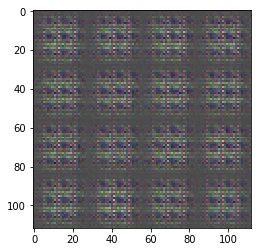

Epoch 1/1 step 10... Generator Loss: 15.2423 Discriminator Loss: 0.6035...
Epoch 1/1 step 20... Generator Loss: 0.0229 Discriminator Loss: 5.7488...
Epoch 1/1 step 30... Generator Loss: 1.3925 Discriminator Loss: 0.9721...
Epoch 1/1 step 40... Generator Loss: 4.0594 Discriminator Loss: 1.6626...
Epoch 1/1 step 50... Generator Loss: 1.2766 Discriminator Loss: 0.8732...
Epoch 1/1 step 60... Generator Loss: 0.3351 Discriminator Loss: 1.9702...
Epoch 1/1 step 70... Generator Loss: 1.2164 Discriminator Loss: 0.9306...
Epoch 1/1 step 80... Generator Loss: 0.7005 Discriminator Loss: 1.1360...
Epoch 1/1 step 90... Generator Loss: 2.4109 Discriminator Loss: 0.8977...
Epoch 1/1 step 100... Generator Loss: 0.4198 Discriminator Loss: 1.7600...


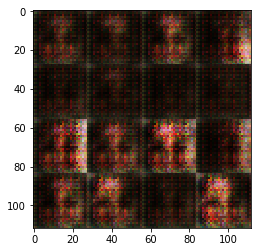

Epoch 1/1 step 110... Generator Loss: 2.8651 Discriminator Loss: 1.4469...
Epoch 1/1 step 120... Generator Loss: 1.3329 Discriminator Loss: 1.0776...
Epoch 1/1 step 130... Generator Loss: 1.1403 Discriminator Loss: 1.0155...
Epoch 1/1 step 140... Generator Loss: 0.6303 Discriminator Loss: 1.3641...
Epoch 1/1 step 150... Generator Loss: 0.6060 Discriminator Loss: 1.7266...
Epoch 1/1 step 160... Generator Loss: 0.9553 Discriminator Loss: 1.0210...
Epoch 1/1 step 170... Generator Loss: 0.9777 Discriminator Loss: 1.1458...
Epoch 1/1 step 180... Generator Loss: 0.0624 Discriminator Loss: 3.6083...
Epoch 1/1 step 190... Generator Loss: 0.7031 Discriminator Loss: 1.5010...
Epoch 1/1 step 200... Generator Loss: 0.8341 Discriminator Loss: 1.5635...


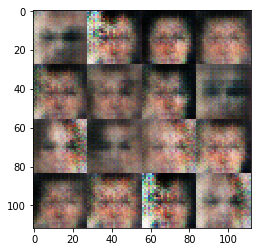

Epoch 1/1 step 210... Generator Loss: 0.9394 Discriminator Loss: 1.2933...
Epoch 1/1 step 220... Generator Loss: 0.7674 Discriminator Loss: 1.5021...
Epoch 1/1 step 230... Generator Loss: 1.0896 Discriminator Loss: 1.1530...
Epoch 1/1 step 240... Generator Loss: 0.9708 Discriminator Loss: 1.2570...
Epoch 1/1 step 250... Generator Loss: 0.8356 Discriminator Loss: 1.3799...
Epoch 1/1 step 260... Generator Loss: 0.8163 Discriminator Loss: 1.3171...
Epoch 1/1 step 270... Generator Loss: 1.0670 Discriminator Loss: 1.0641...
Epoch 1/1 step 280... Generator Loss: 1.0053 Discriminator Loss: 1.3483...
Epoch 1/1 step 290... Generator Loss: 0.9868 Discriminator Loss: 1.6703...
Epoch 1/1 step 300... Generator Loss: 1.4108 Discriminator Loss: 0.8921...


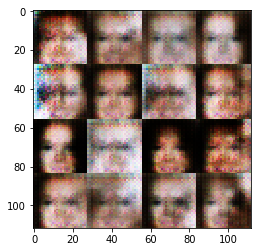

Epoch 1/1 step 310... Generator Loss: 1.1399 Discriminator Loss: 1.1931...
Epoch 1/1 step 320... Generator Loss: 0.8417 Discriminator Loss: 1.2839...
Epoch 1/1 step 330... Generator Loss: 0.9524 Discriminator Loss: 1.2011...
Epoch 1/1 step 340... Generator Loss: 0.8958 Discriminator Loss: 1.2676...
Epoch 1/1 step 350... Generator Loss: 0.9415 Discriminator Loss: 1.0402...
Epoch 1/1 step 360... Generator Loss: 0.5060 Discriminator Loss: 1.4225...
Epoch 1/1 step 370... Generator Loss: 2.1343 Discriminator Loss: 1.8975...
Epoch 1/1 step 380... Generator Loss: 1.2367 Discriminator Loss: 1.3794...
Epoch 1/1 step 390... Generator Loss: 0.6287 Discriminator Loss: 1.2819...
Epoch 1/1 step 400... Generator Loss: 1.3449 Discriminator Loss: 1.0943...


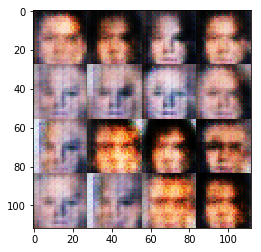

Epoch 1/1 step 410... Generator Loss: 1.2430 Discriminator Loss: 0.8817...
Epoch 1/1 step 420... Generator Loss: 1.5203 Discriminator Loss: 0.7096...
Epoch 1/1 step 430... Generator Loss: 0.5559 Discriminator Loss: 1.4881...
Epoch 1/1 step 440... Generator Loss: 2.1101 Discriminator Loss: 1.2691...
Epoch 1/1 step 450... Generator Loss: 2.6209 Discriminator Loss: 1.8692...
Epoch 1/1 step 460... Generator Loss: 0.7597 Discriminator Loss: 1.3418...
Epoch 1/1 step 470... Generator Loss: 1.3050 Discriminator Loss: 0.8407...
Epoch 1/1 step 480... Generator Loss: 2.8734 Discriminator Loss: 1.8309...
Epoch 1/1 step 490... Generator Loss: 1.1123 Discriminator Loss: 0.9609...
Epoch 1/1 step 500... Generator Loss: 1.0187 Discriminator Loss: 1.0902...


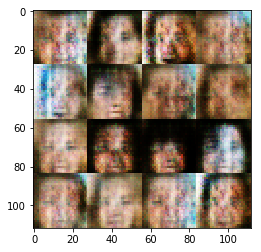

Epoch 1/1 step 510... Generator Loss: 0.9613 Discriminator Loss: 1.0598...
Epoch 1/1 step 520... Generator Loss: 0.9912 Discriminator Loss: 1.2453...
Epoch 1/1 step 530... Generator Loss: 1.1021 Discriminator Loss: 1.1674...
Epoch 1/1 step 540... Generator Loss: 1.2252 Discriminator Loss: 0.9414...
Epoch 1/1 step 550... Generator Loss: 1.7354 Discriminator Loss: 1.0021...
Epoch 1/1 step 560... Generator Loss: 1.5760 Discriminator Loss: 1.4043...
Epoch 1/1 step 570... Generator Loss: 0.9261 Discriminator Loss: 1.4435...
Epoch 1/1 step 580... Generator Loss: 1.1565 Discriminator Loss: 1.0100...
Epoch 1/1 step 590... Generator Loss: 1.1804 Discriminator Loss: 0.9439...
Epoch 1/1 step 600... Generator Loss: 0.5549 Discriminator Loss: 1.5629...


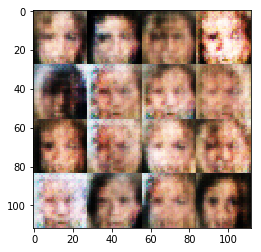

Epoch 1/1 step 610... Generator Loss: 0.9451 Discriminator Loss: 1.2329...
Epoch 1/1 step 620... Generator Loss: 1.0696 Discriminator Loss: 1.1890...
Epoch 1/1 step 630... Generator Loss: 1.2508 Discriminator Loss: 1.1266...
Epoch 1/1 step 640... Generator Loss: 1.5732 Discriminator Loss: 1.3369...
Epoch 1/1 step 650... Generator Loss: 0.5646 Discriminator Loss: 1.3834...
Epoch 1/1 step 660... Generator Loss: 1.2385 Discriminator Loss: 1.0088...
Epoch 1/1 step 670... Generator Loss: 0.8982 Discriminator Loss: 1.2681...
Epoch 1/1 step 680... Generator Loss: 0.8468 Discriminator Loss: 1.2174...
Epoch 1/1 step 690... Generator Loss: 1.0339 Discriminator Loss: 1.0686...
Epoch 1/1 step 700... Generator Loss: 0.6806 Discriminator Loss: 1.2167...


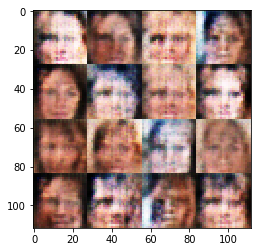

Epoch 1/1 step 710... Generator Loss: 0.9329 Discriminator Loss: 1.0934...
Epoch 1/1 step 720... Generator Loss: 1.6847 Discriminator Loss: 1.3413...
Epoch 1/1 step 730... Generator Loss: 0.7424 Discriminator Loss: 1.4275...
Epoch 1/1 step 740... Generator Loss: 0.1904 Discriminator Loss: 2.2811...
Epoch 1/1 step 750... Generator Loss: 1.0117 Discriminator Loss: 1.1800...
Epoch 1/1 step 760... Generator Loss: 1.2377 Discriminator Loss: 1.1438...
Epoch 1/1 step 770... Generator Loss: 1.5633 Discriminator Loss: 1.4066...
Epoch 1/1 step 780... Generator Loss: 1.3478 Discriminator Loss: 1.1811...
Epoch 1/1 step 790... Generator Loss: 1.4634 Discriminator Loss: 1.6346...
Epoch 1/1 step 800... Generator Loss: 0.9669 Discriminator Loss: 1.1505...


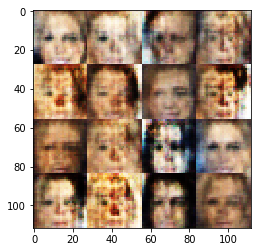

Epoch 1/1 step 810... Generator Loss: 1.4746 Discriminator Loss: 0.9359...
Epoch 1/1 step 820... Generator Loss: 1.2064 Discriminator Loss: 1.0851...
Epoch 1/1 step 830... Generator Loss: 0.9343 Discriminator Loss: 1.1877...
Epoch 1/1 step 840... Generator Loss: 1.0078 Discriminator Loss: 1.1876...
Epoch 1/1 step 850... Generator Loss: 0.6056 Discriminator Loss: 1.3476...
Epoch 1/1 step 860... Generator Loss: 1.0461 Discriminator Loss: 1.0789...
Epoch 1/1 step 870... Generator Loss: 0.6184 Discriminator Loss: 1.3263...
Epoch 1/1 step 880... Generator Loss: 0.9557 Discriminator Loss: 1.0662...
Epoch 1/1 step 890... Generator Loss: 2.3154 Discriminator Loss: 1.4110...
Epoch 1/1 step 900... Generator Loss: 0.9253 Discriminator Loss: 1.0633...


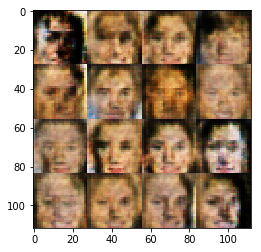

Epoch 1/1 step 910... Generator Loss: 0.4030 Discriminator Loss: 1.6175...
Epoch 1/1 step 920... Generator Loss: 1.0143 Discriminator Loss: 1.1796...
Epoch 1/1 step 930... Generator Loss: 1.4978 Discriminator Loss: 1.1306...
Epoch 1/1 step 940... Generator Loss: 0.6262 Discriminator Loss: 1.3894...
Epoch 1/1 step 950... Generator Loss: 0.3886 Discriminator Loss: 1.8037...
Epoch 1/1 step 960... Generator Loss: 0.7860 Discriminator Loss: 1.2074...
Epoch 1/1 step 970... Generator Loss: 0.8560 Discriminator Loss: 1.2478...
Epoch 1/1 step 980... Generator Loss: 1.1813 Discriminator Loss: 1.1675...
Epoch 1/1 step 990... Generator Loss: 0.7298 Discriminator Loss: 1.3098...
Epoch 1/1 step 1000... Generator Loss: 1.1647 Discriminator Loss: 1.1884...


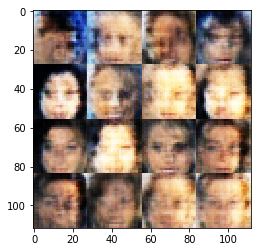

Epoch 1/1 step 1010... Generator Loss: 0.5061 Discriminator Loss: 1.4447...
Epoch 1/1 step 1020... Generator Loss: 1.1830 Discriminator Loss: 1.1854...
Epoch 1/1 step 1030... Generator Loss: 1.3219 Discriminator Loss: 1.2310...
Epoch 1/1 step 1040... Generator Loss: 1.3297 Discriminator Loss: 1.1865...
Epoch 1/1 step 1050... Generator Loss: 0.8781 Discriminator Loss: 1.3004...
Epoch 1/1 step 1060... Generator Loss: 0.9419 Discriminator Loss: 1.0810...
Epoch 1/1 step 1070... Generator Loss: 0.9092 Discriminator Loss: 1.1739...
Epoch 1/1 step 1080... Generator Loss: 1.4428 Discriminator Loss: 1.2581...
Epoch 1/1 step 1090... Generator Loss: 1.4966 Discriminator Loss: 1.1964...
Epoch 1/1 step 1100... Generator Loss: 0.5222 Discriminator Loss: 1.4389...


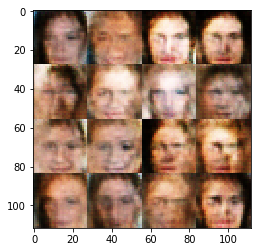

Epoch 1/1 step 1110... Generator Loss: 0.7916 Discriminator Loss: 1.3536...
Epoch 1/1 step 1120... Generator Loss: 0.6552 Discriminator Loss: 1.3508...
Epoch 1/1 step 1130... Generator Loss: 0.8025 Discriminator Loss: 1.1453...
Epoch 1/1 step 1140... Generator Loss: 1.2024 Discriminator Loss: 1.2410...
Epoch 1/1 step 1150... Generator Loss: 0.9700 Discriminator Loss: 1.0399...
Epoch 1/1 step 1160... Generator Loss: 0.9085 Discriminator Loss: 1.1960...
Epoch 1/1 step 1170... Generator Loss: 1.2608 Discriminator Loss: 1.1594...
Epoch 1/1 step 1180... Generator Loss: 1.1981 Discriminator Loss: 1.1222...
Epoch 1/1 step 1190... Generator Loss: 1.5486 Discriminator Loss: 1.2067...
Epoch 1/1 step 1200... Generator Loss: 0.5679 Discriminator Loss: 1.3633...


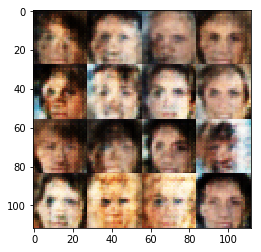

Epoch 1/1 step 1210... Generator Loss: 0.7605 Discriminator Loss: 1.2294...
Epoch 1/1 step 1220... Generator Loss: 0.9584 Discriminator Loss: 1.1438...
Epoch 1/1 step 1230... Generator Loss: 1.2345 Discriminator Loss: 1.2742...
Epoch 1/1 step 1240... Generator Loss: 1.2118 Discriminator Loss: 1.1484...
Epoch 1/1 step 1250... Generator Loss: 2.1294 Discriminator Loss: 1.5842...
Epoch 1/1 step 1260... Generator Loss: 0.5766 Discriminator Loss: 1.3910...
Epoch 1/1 step 1270... Generator Loss: 1.5938 Discriminator Loss: 1.2873...
Epoch 1/1 step 1280... Generator Loss: 1.2663 Discriminator Loss: 1.1689...
Epoch 1/1 step 1290... Generator Loss: 0.7991 Discriminator Loss: 1.3554...
Epoch 1/1 step 1300... Generator Loss: 0.9494 Discriminator Loss: 1.1040...


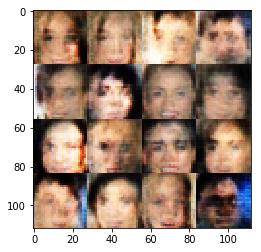

Epoch 1/1 step 1310... Generator Loss: 0.9181 Discriminator Loss: 1.2912...
Epoch 1/1 step 1320... Generator Loss: 1.0743 Discriminator Loss: 0.9788...
Epoch 1/1 step 1330... Generator Loss: 1.3003 Discriminator Loss: 1.3021...
Epoch 1/1 step 1340... Generator Loss: 1.5798 Discriminator Loss: 1.3066...
Epoch 1/1 step 1350... Generator Loss: 0.9993 Discriminator Loss: 1.1745...
Epoch 1/1 step 1360... Generator Loss: 0.7501 Discriminator Loss: 1.2630...
Epoch 1/1 step 1370... Generator Loss: 1.1057 Discriminator Loss: 1.2482...
Epoch 1/1 step 1380... Generator Loss: 0.6993 Discriminator Loss: 1.2838...
Epoch 1/1 step 1390... Generator Loss: 0.9485 Discriminator Loss: 1.1838...
Epoch 1/1 step 1400... Generator Loss: 1.3002 Discriminator Loss: 1.1235...


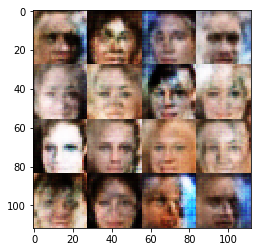

Epoch 1/1 step 1410... Generator Loss: 1.9459 Discriminator Loss: 1.1827...
Epoch 1/1 step 1420... Generator Loss: 2.3261 Discriminator Loss: 1.7247...
Epoch 1/1 step 1430... Generator Loss: 1.1185 Discriminator Loss: 1.1040...
Epoch 1/1 step 1440... Generator Loss: 0.6596 Discriminator Loss: 1.3178...
Epoch 1/1 step 1450... Generator Loss: 1.1791 Discriminator Loss: 1.1076...
Epoch 1/1 step 1460... Generator Loss: 1.8254 Discriminator Loss: 1.2903...
Epoch 1/1 step 1470... Generator Loss: 0.8926 Discriminator Loss: 1.2411...
Epoch 1/1 step 1480... Generator Loss: 1.0085 Discriminator Loss: 1.1319...
Epoch 1/1 step 1490... Generator Loss: 0.4644 Discriminator Loss: 1.5039...
Epoch 1/1 step 1500... Generator Loss: 1.1596 Discriminator Loss: 1.1601...


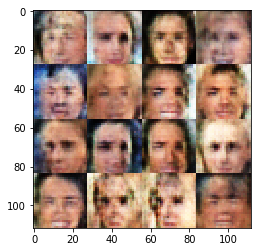

Epoch 1/1 step 1510... Generator Loss: 1.4409 Discriminator Loss: 1.1906...
Epoch 1/1 step 1520... Generator Loss: 0.9078 Discriminator Loss: 1.1038...
Epoch 1/1 step 1530... Generator Loss: 0.8285 Discriminator Loss: 1.1999...
Epoch 1/1 step 1540... Generator Loss: 2.2242 Discriminator Loss: 1.4805...
Epoch 1/1 step 1550... Generator Loss: 0.8036 Discriminator Loss: 1.2965...
Epoch 1/1 step 1560... Generator Loss: 0.9505 Discriminator Loss: 1.2751...
Epoch 1/1 step 1570... Generator Loss: 1.1027 Discriminator Loss: 1.3412...
Epoch 1/1 step 1580... Generator Loss: 1.4782 Discriminator Loss: 1.0705...
Epoch 1/1 step 1590... Generator Loss: 0.8286 Discriminator Loss: 1.1246...
Epoch 1/1 step 1600... Generator Loss: 1.1791 Discriminator Loss: 1.2368...


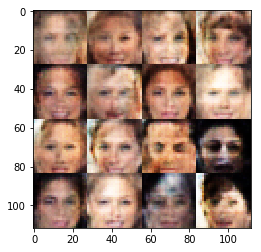

Epoch 1/1 step 1610... Generator Loss: 1.1265 Discriminator Loss: 1.0054...
Epoch 1/1 step 1620... Generator Loss: 1.0731 Discriminator Loss: 1.1508...
Epoch 1/1 step 1630... Generator Loss: 2.1453 Discriminator Loss: 1.6701...
Epoch 1/1 step 1640... Generator Loss: 1.3006 Discriminator Loss: 1.1874...
Epoch 1/1 step 1650... Generator Loss: 1.2159 Discriminator Loss: 0.9672...
Epoch 1/1 step 1660... Generator Loss: 0.5774 Discriminator Loss: 1.4217...
Epoch 1/1 step 1670... Generator Loss: 1.1997 Discriminator Loss: 1.1039...
Epoch 1/1 step 1680... Generator Loss: 0.3901 Discriminator Loss: 1.6442...
Epoch 1/1 step 1690... Generator Loss: 0.7977 Discriminator Loss: 1.1562...
Epoch 1/1 step 1700... Generator Loss: 0.4912 Discriminator Loss: 1.4416...


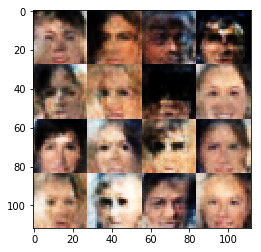

Epoch 1/1 step 1710... Generator Loss: 0.6300 Discriminator Loss: 1.3709...
Epoch 1/1 step 1720... Generator Loss: 0.6741 Discriminator Loss: 1.2890...
Epoch 1/1 step 1730... Generator Loss: 1.9531 Discriminator Loss: 1.2350...
Epoch 1/1 step 1740... Generator Loss: 0.9096 Discriminator Loss: 1.1563...
Epoch 1/1 step 1750... Generator Loss: 1.3446 Discriminator Loss: 1.2617...
Epoch 1/1 step 1760... Generator Loss: 1.0074 Discriminator Loss: 1.1649...
Epoch 1/1 step 1770... Generator Loss: 1.5468 Discriminator Loss: 1.1569...
Epoch 1/1 step 1780... Generator Loss: 1.0804 Discriminator Loss: 1.0930...
Epoch 1/1 step 1790... Generator Loss: 1.2473 Discriminator Loss: 1.2011...
Epoch 1/1 step 1800... Generator Loss: 1.0740 Discriminator Loss: 1.1175...


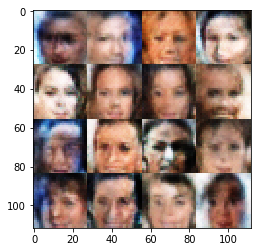

Epoch 1/1 step 1810... Generator Loss: 0.9374 Discriminator Loss: 1.2003...
Epoch 1/1 step 1820... Generator Loss: 1.9687 Discriminator Loss: 1.2721...
Epoch 1/1 step 1830... Generator Loss: 1.1605 Discriminator Loss: 1.1566...
Epoch 1/1 step 1840... Generator Loss: 1.4462 Discriminator Loss: 1.1737...
Epoch 1/1 step 1850... Generator Loss: 0.8535 Discriminator Loss: 1.1953...
Epoch 1/1 step 1860... Generator Loss: 0.9814 Discriminator Loss: 1.2500...
Epoch 1/1 step 1870... Generator Loss: 1.3560 Discriminator Loss: 1.2111...
Epoch 1/1 step 1880... Generator Loss: 0.8952 Discriminator Loss: 1.1141...
Epoch 1/1 step 1890... Generator Loss: 0.5942 Discriminator Loss: 1.3096...
Epoch 1/1 step 1900... Generator Loss: 0.9933 Discriminator Loss: 1.1746...


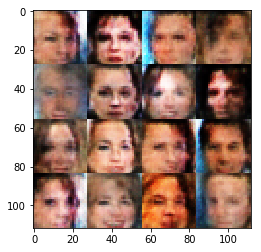

Epoch 1/1 step 1910... Generator Loss: 1.1171 Discriminator Loss: 1.3508...
Epoch 1/1 step 1920... Generator Loss: 0.7466 Discriminator Loss: 1.1713...
Epoch 1/1 step 1930... Generator Loss: 1.1173 Discriminator Loss: 1.0747...
Epoch 1/1 step 1940... Generator Loss: 1.0998 Discriminator Loss: 1.1772...
Epoch 1/1 step 1950... Generator Loss: 1.3899 Discriminator Loss: 1.1338...
Epoch 1/1 step 1960... Generator Loss: 0.7163 Discriminator Loss: 1.2318...
Epoch 1/1 step 1970... Generator Loss: 1.0280 Discriminator Loss: 1.0737...
Epoch 1/1 step 1980... Generator Loss: 1.1597 Discriminator Loss: 1.0197...
Epoch 1/1 step 1990... Generator Loss: 0.4823 Discriminator Loss: 1.5443...
Epoch 1/1 step 2000... Generator Loss: 1.5514 Discriminator Loss: 1.2771...


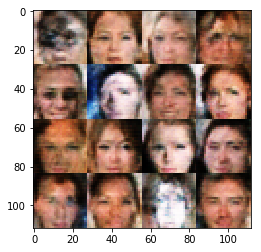

Epoch 1/1 step 2010... Generator Loss: 1.2395 Discriminator Loss: 1.1850...
Epoch 1/1 step 2020... Generator Loss: 0.9033 Discriminator Loss: 1.1495...
Finished with trainning


In [13]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.